In [1]:
import sys
sys.path.insert(1, "./src")

In [2]:
from pathlib import Path
import yaml
import pytorch_lightning as pl
from torch.utils.data import DataLoader
from transformers import set_seed


from datasets.ner_dataset import get_ner_dataset
from models.bert_model import PretrainedBertNER
from utils.ner_metrics import Statistics
from utils.log_reader import TensorBoardReader
from anonymization.gpt2_generation import GPT2GenerationAnonymization
from models.gpt2_model import PretrainedGPT2TextInfilling
from mask.personal_entity import MaskEntityType

In [3]:
set_seed(42)

In [4]:
# Data config initialisation
i2b2_2006_data_config = yaml.load(open("configs/i2b2-2006_data_config.yaml", 'r'), Loader=yaml.Loader)
i2b2_2014_data_config = yaml.load(open("configs/i2b2-2014_data_config.yaml", 'r'), Loader=yaml.Loader)

In [5]:
# Model config initialisation
bert_base_model_config = yaml.load(open("configs/bert-base_model_config.yaml", 'r'), Loader=yaml.Loader)
bert_large_model_config = yaml.load(open("configs/bert-large_model_config.yaml", 'r'), Loader=yaml.Loader)

In [6]:
# Anonymization config initialisation
anon_config = yaml.load(open("configs/ref_book_anonymization_config.yaml", 'r'), Loader=yaml.Loader)
anon_gpt2_config = yaml.load(open("configs/gpt2_anonymization_config.yaml", 'r'), Loader=yaml.Loader)

In [ ]:
anon_gpt2_config["model_version"] = 14
bert_large_model_config["model_version"] = 9

### Структура сохранённых моделей:
1. В ```./bert-base/lightning_logs/``` должны храниться модели, основанные на базовом предобученном BERT
    1. Version 0 --- обученная на нетронутом тренировочном наборе данных i2b2 2006 с учётом регистра
    2. Version 1 --- обученная на нетронутом тренировочном наборе данных i2b2 2006 без учёта регистра
    3. Version 2 --- обученная на нетронутом тренировочном наборе данных i2b2 2014 с учётом регистра
    4. Version 3 --- обученная на нетронутом тренировочном наборе данных i2b2 2014 без учёта регистра
2. В ```./bert-large/lightning_logs/``` должны храниться модели, основанные на большом предобученном BERT
    1. Version 0 --- обученная на нетронутом тренировочном наборе данных i2b2 2006 с учётом регистра
    2. Version 1 --- обученная на нетронутом тренировочном наборе данных i2b2 2006 без учёта регистра
    3. Version 2 --- обученная на нетронутом тренировочном наборе данных i2b2 2014 с учётом регистра
    4. Version 3 --- обученная на нетронутом тренировочном наборе данных i2b2 2014 без учёта регистра
    5. Version 4 --- обученная на анонимизированном с помощью справочников наборе данных i2b2 2014 без учёта регистра
    6. Version 5 --- обученная на анонимизированном с помощью GPT2 валидационном наборе данных i2b2 2014 без учёта регистра, (11) GPT2 обучено на тренировочном наборе данных i2b2 2014 
    7. Version 6 --- обученная на анонимизированном с помощью GPT2 тренировочном наборе данных i2b2 2006 без учёта регистра, (11) GPT2 обучено на тренировочном наборе данных i2b2 2014 
    8. Version 7 --- обученная на нетронутом валидационном наборе данных i2b2 2014 без учёта регистра
    9. Version 8 --- обученная на анонимизированном с помощью GPT2 тренировочном наборе данных i2b2 2006 без учёта регистра, (12) GPT2 со второй головой, определяющей тип генерации, обучено на тренировочном наборе данных i2b2 2014
    10. Version 8 --- обученная на анонимизированном с помощью GPT2 валидационном наборе данных i2b2 2014 без учёта регистра, (12) GPT2 со второй головой, определяющей тип генерации, обучено на тренировочном наборе данных i2b2 2014

### Этап 1: Демонстрация качества искусственных примеров личных сущностей
Правдоподобность искусственных примеров будет оцениваться по метрикам их определения лучшей NER моделью --- BERT-large-uncased, дообученной на i2b2 2014

In [8]:
# Инициализация алгоритма генерации искусственных сущностей на основе справочника
model_reader = TensorBoardReader(Path(anon_gpt2_config["log_dir"]) / Path("lightning_logs"))
path_to_checkpoint = model_reader.get_ckpt_path(anon_gpt2_config["model_version"])
text_infill_model = PretrainedGPT2TextInfilling.load_from_checkpoint(path_to_checkpoint, strict=False).to("cuda:0")
text_infill_model.eval()
anonymization = GPT2GenerationAnonymization(text_infill_model,
                                            label2type=lambda x: MaskEntityType[x.upper()],
                                            mask_types=list(MaskEntityType), **anon_gpt2_config)

/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/pytorch_lightning/core/saving.py:188: Found keys that are not in the model state dict but in the checkpoint: ['ner_model.model.embeddings.word_embeddings.weight', 'ner_model.model.embeddings.position_embeddings.weight', 'ner_model.model.embeddings.token_type_embeddings.weight', 'ner_model.model.embeddings.LayerNorm.weight', 'ner_model.model.embeddings.LayerNorm.bias', 'ner_model.model.encoder.layer.0.attention.self.query.weight', 'ner_model.model.encoder.layer.0.attention.self.query.bias', 'ner_model.model.encoder.layer.0.attention.self.key.weight', 'ner_model.model.encoder.layer.0.attention.self.key.bias', 'ner_model.model.encoder.layer.0.attention.self.value.weight', 'ner_model.model.encoder.layer.0.attention.self.value.bias', 'ner_model.model.encoder.layer.0.attention.output.dense.weight', 'ner_model.model.encoder.layer.0.attention.output.dense.bias', 'ner_model.model.encoder.layer.0.attention.output.LayerNorm.weight', 'ne

In [9]:
# Инициализация обезличенного тестового датасета
test_dataset = get_ner_dataset(path_to_folder=i2b2_2014_data_config["validate_data_path"], 
                               anonymization=anonymization, device='cpu',
                               **i2b2_2014_data_config)
test_dataloader = DataLoader(test_dataset, shuffle=False,
                             batch_size=i2b2_2014_data_config["batch_size"],
                             collate_fn=test_dataset.get_collate_fn(),
                             num_workers=10,
                             pin_memory=False,
                             persistent_workers=True)

Start data tokenization


  0%|          | 0/514 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (1234 > 512). Running this sequence through the model will result in indexing errors


In [10]:
# Инициализация модели
t_reader = TensorBoardReader(Path(bert_large_model_config["log_dir"]) / Path("lightning_logs"))
ner_model = PretrainedBertNER.load_from_checkpoint(t_reader.get_ckpt_path(3))

In [11]:
# Тестирование
trainer_args = {
    "accelerator": "gpu",
    "logger": False
}
trainer = pl.Trainer(**trainer_args, enable_progress_bar=True)
trainer.test(ner_model, test_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4080') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |                                                                                                    …

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.
/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/pytorch_lightning/core/module.py:507: You called `self.log('test_recall', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/pytorch_lightning/core/module.py:507: You called `self.log('test_precision', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/pytorch_lightning/core/module.py:507: You called `self.log('test_f1', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         test_f1            0.9752020835876465
     test_precision         0.9752020835876465
       test_recall          0.5962488651275635
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_recall': 0.5962488651275635,
  'test_precision': 0.9752020835876465,
  'test_f1': 0.9752020835876465}]

  0%|          | 0/864 [00:00<?, ?it/s]

              precision    recall  f1-score   support

        NAME     0.8775    0.7320    0.7982     29444
  PROFESSION     0.4874    0.1667    0.2484       348
    LOCATION     0.3562    0.5642    0.4367      7426
         AGE     0.8431    0.6133    0.7101      1218
        DATE     0.6032    0.5587    0.5801     22580
          ID     0.2368    0.1334    0.1706      4229
     CONTACT     0.6510    0.3880    0.4862      3961

   micro avg     0.6551    0.5962    0.6243     69206
   macro avg     0.5793    0.4509    0.4900     69206
weighted avg     0.6774    0.5962    0.6277     69206



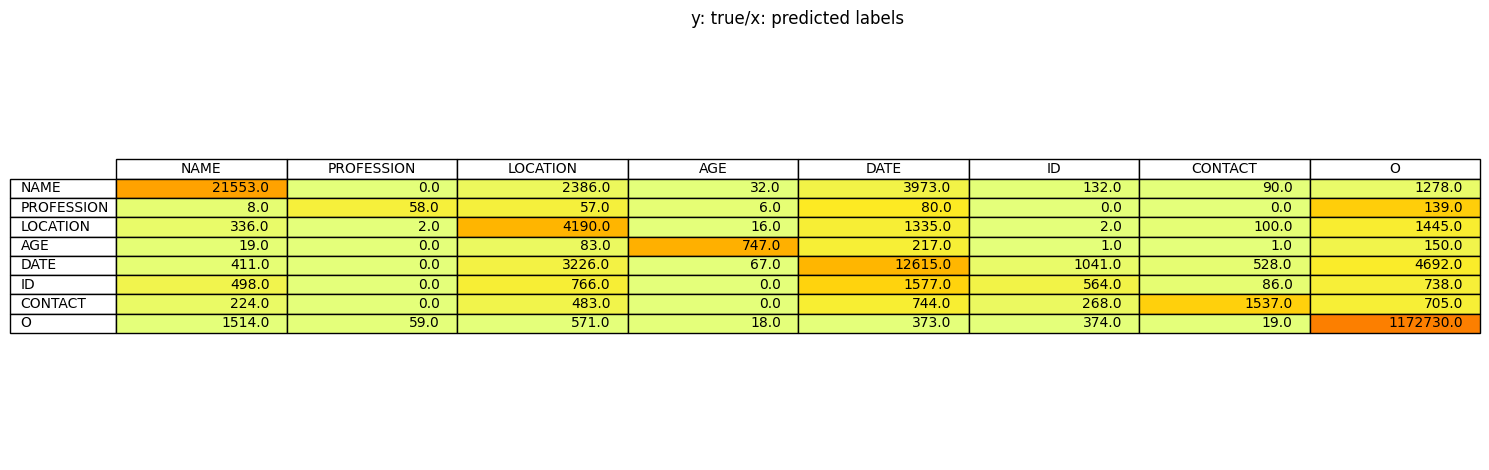

Wrongly predicted examples:
_____ Record 167-04:2066 _____
| Sentence:    | pager | 1865    | ) |
| True labels: | O     | CONTACT | O |
| Sentence:    | pager 1865 ) |
| Pred labels: | O            |
_____ Record 268-01:1202 _____
| Sentence:    | . careful glycemic control ( holding metformin ). | laurence | , m. d., ph. d. resident, | geoffrey macdonald | neurology |
| True labels: | O                                                 | NAME     | O                         | LOCATION           | O         |
| Sentence:    | . careful glycemic control ( holding metformin ). | laurence | , m. d., ph. d. resident, | geoffrey macdonald | neurology |
| Pred labels: | O                                                 | NAME     | O                         | NAME               | O         |
_____ Record 215-03:360 _____
| Sentence:    | / v, abdominal pain, diarrhea. past medical / surgical history : cad s / p mi & cabg ( | 1865 | : lima to lad, svg to pda, radial artery to om1 ) ; last cath

In [12]:
# Метрики
stats = Statistics(ner_model, test_dataloader)
print(stats.get_classification_report())
stats.plot_confusion_matrix()
stats.print_random_failed_predictions()

In [13]:
# import importlib
# ner_metrics = importlib.import_module('utils.ner_metrics')
# ner_metrics = importlib.reload(ner_metrics)

In [14]:
stats.get_specific_failed_predictions('LOCATION')

Wrongly predicted examples:
_____ Record 118-04:670 _____
| Sentence:    | labs ( check ptt, inr ) - regular diet. patient has been seen by | roger | , senior resident | john     | internal medicine | 1865 | , md | 1965     | surgery |
| True labels: | O                                                                | NAME  | O                 | LOCATION | O                 | NAME | O    | LOCATION | O       |
| Sentence:    | labs ( check ptt, inr ) - regular diet. patient has been seen by | roger | , senior resident | john | internal medicine | 1865 | , md | 1965 | surgery |
| Pred labels: | O                                                                | NAME  | O                 | NAME | O                 | NAME | O    | DATE | O       |
_____ Record 266-03:1173 _____
| Sentence:    | in print in the patient's | 1965     | paper record. |
| True labels: | O                         | LOCATION | O             |
| Sentence:    | in print in the patient's 1965 paper record. |
| Pred 

['110-03:718',
 '110-03:735',
 '110-03:739',
 '110-03:740',
 '110-03:743',
 '110-03:744',
 '110-03:745',
 '110-03:746',
 '110-03:747',
 '110-03:748',
 '110-03:749',
 '110-03:750',
 '110-03:751',
 '110-03:752',
 '110-03:753',
 '110-03:754',
 '110-03:755',
 '110-03:756',
 '110-03:757',
 '110-03:758',
 '110-03:759',
 '110-03:760',
 '110-03:761',
 '110-03:762',
 '110-03:763',
 '110-03:764',
 '110-03:765',
 '110-03:766',
 '110-03:767',
 '110-03:768',
 '110-03:769',
 '110-03:770',
 '110-03:771',
 '112-01:297',
 '112-01:357',
 '112-02:0',
 '112-02:599',
 '112-02:629',
 '112-02:630',
 '112-02:631',
 '112-02:632',
 '112-02:633',
 '112-02:634',
 '112-02:635',
 '112-02:636',
 '112-02:639',
 '112-02:640',
 '112-02:641',
 '112-02:642',
 '112-02:647',
 '112-03:0',
 '112-03:178',
 '112-04:0',
 '112-04:420',
 '112-04:422',
 '112-04:423',
 '112-04:424',
 '112-04:425',
 '112-04:426',
 '112-04:427',
 '112-04:428',
 '112-04:429',
 '112-04:430',
 '112-04:431',
 '112-04:432',
 '112-04:433',
 '112-04:434',
 

In [15]:
stats.get_specific_failed_predictions('CONTACT')

Wrongly predicted examples:
_____ Record 387-03:615 _____
| Sentence:    | balance of plan per dr. | stewart | . | john | , md, phd pager | 1981    |
| True labels: | O                       | NAME    | O | NAME | O               | CONTACT |
| Sentence:    | balance of plan per dr. | stewart. john | , md, phd pager 1981 |
| Pred labels: | O                       | NAME          | O                    |
_____ Record 387-03:622 _____
| Sentence:    | . | john | , md, phd pager | 1981    |
| True labels: | O | NAME | O               | CONTACT |
| Sentence:    | . john | , md, phd pager 1981 |
| Pred labels: | NAME   | O                    |


['110-03:735',
 '110-03:764',
 '110-03:765',
 '110-03:766',
 '110-03:767',
 '110-03:768',
 '110-03:769',
 '110-03:770',
 '110-03:772',
 '110-03:774',
 '112-02:0',
 '114-04:0',
 '114-04:1960',
 '114-04:1961',
 '115-04:0',
 '115-04:1251',
 '115-04:476',
 '118-01:1134',
 '118-01:1176',
 '118-01:1177',
 '118-01:1178',
 '118-01:1179',
 '118-01:1180',
 '118-01:1181',
 '118-01:1182',
 '118-01:1183',
 '118-01:1184',
 '118-01:1185',
 '118-01:1186',
 '118-01:1187',
 '118-01:1188',
 '118-01:1189',
 '118-01:1190',
 '118-01:1191',
 '118-01:1192',
 '118-01:1193',
 '118-01:1194',
 '118-01:1195',
 '118-01:1196',
 '118-01:1197',
 '118-01:1198',
 '118-01:1199',
 '118-01:1200',
 '118-01:1201',
 '118-01:1202',
 '118-01:1203',
 '118-01:1204',
 '118-01:1205',
 '118-01:1206',
 '118-01:1207',
 '118-01:1208',
 '118-01:1209',
 '118-01:1210',
 '118-01:1211',
 '118-01:1212',
 '118-01:1213',
 '118-01:1214',
 '118-01:1215',
 '118-02:535',
 '118-02:595',
 '118-05:1973',
 '118-05:2020',
 '118-05:2021',
 '118-05:2022'

**Вывод:**  
В целом все метки предсказываются с точностью, близкой к аналогичной у первоначальных сущностей. Самое низкое качество распознавания у модели оказалось для класса 'LOCATION', предположительно, из-за слишком длинных названий больниц в используемом справочнике. Однако в первых версиях генератора синтетических данных присутствовали проблемы с меткой 'CONTACT'. Основная трудность для модели заключалась в предсказании номеров телефонов, если их генерация использовала российский стиль их написания. Тогда модель определяла его, как уникальный идентификатор. Проблема была решена сменной формата номера.  
  
Как видно, в оригинальных данных не используется код страны, и цифры сгруппированы отлично от распространённого российского варианта.  
Запись **347-03**  
Original:  (121) 537-3484  
Russian format: +1 933 257-12-32  
Запись **314-02**  
Original:  (676) 312-7662  
Russian format: +1 995 672-52-24  
  
Ещё один вариант записи номера телефона в оригинальных данных: "665-578-7821"

### Этап 2: Обучение NER на анонимизированных с помощью ILM данных из того же набора

In [7]:
t_reader = TensorBoardReader(Path(bert_large_model_config["log_dir"]) / Path("lightning_logs"))
t_reader.plot_ner_tensorboard_graphics(bert_large_model_config["model_version"])

Из обучения взята модель с лучшим показателем в метрике recall без учёта класса 'other'. Посмотрим на её метрики на валидационных данных.

In [8]:
# Data processing
test_dataset = get_ner_dataset(path_to_folder=i2b2_2014_data_config["train_data_path"], device='cpu', **i2b2_2014_data_config)
test_dataloader = DataLoader(test_dataset, shuffle=False,
                             batch_size=i2b2_2014_data_config["batch_size"],
                             collate_fn=test_dataset.get_collate_fn(),
                             num_workers=10,
                             pin_memory=False,
                             persistent_workers=True)

In [9]:
# Model initialisation
path_to_checkpoint = t_reader.get_ckpt_path(bert_large_model_config["model_version"])
ner_model = PretrainedBertNER.load_from_checkpoint(path_to_checkpoint)
print(ner_model)

In [10]:
# Testing
trainer_args = {
    "accelerator": "gpu",
    "logger": False
}
trainer = pl.Trainer(**trainer_args, enable_progress_bar=True)
trainer.test(ner_model, test_dataloader)

In [11]:
# Print metrics
stats = Statistics(ner_model, test_dataloader)
print(stats.get_classification_report())
stats.plot_confusion_matrix()
stats.print_random_failed_predictions()

In [12]:
stats.get_specific_failed_predictions('PROFESSION')

In [13]:
stats.get_specific_failed_predictions('CONTACT')

**Вывод:**  
Заметим, что из-за малого разнообразия формата данных наблюдается переобучение модели после $6$-ой эпохи. Также общее качество работы модели заметно уменьшилось до Recall $=78.71\%$. При этом модель часто принимала класс 'ID' за 'CONTACT', так как искусственно сгенерированные идентификаторы представляют собой непрерываемый поток цифр. Самое же большое падение качества наблюдается в распознавании идентификаторов и имён. Приведём примеры их ошибок, связанных в основном с малым количеством форматов у синтетических данных:

### Этап 3: Обучение NER на анонимизированных с помошью ILM данных из другого набора в том же домене

In [15]:
# Data processing
test_dataset = get_ner_dataset(path_to_folder=i2b2_2006_data_config["validate_data_path"], device='cpu', **i2b2_2006_data_config)
test_dataloader = DataLoader(test_dataset, shuffle=False,
                             batch_size=i2b2_2006_data_config["batch_size"],
                             collate_fn=test_dataset.get_collate_fn(),
                             num_workers=10,
                             pin_memory=False,
                             persistent_workers=True)

In [17]:
# Testing
trainer_args = {
    "accelerator": "gpu",
    "logger": False
}
trainer = pl.Trainer(**trainer_args, enable_progress_bar=True)
trainer.test(ner_model, test_dataloader)

In [18]:
# Print metrics
stats = Statistics(ner_model, test_dataloader)
print(stats.get_classification_report())
stats.plot_confusion_matrix()
stats.print_random_failed_predictions()

In [19]:
stats.get_specific_failed_predictions('LOCATION')

In [20]:
stats.get_specific_failed_predictions('ID')

**Вывод:**  
Заметим, что из-за малого разнообразия формата данных наблюдается переобучение модели после $6$-ой эпохи. Также общее качество работы модели заметно уменьшилось до Recall $=78.71\%$. При этом модель часто принимала класс 'ID' за 'CONTACT', так как искусственно сгенерированные идентификаторы представляют собой непрерываемый поток цифр. Самое же большое падение качества наблюдается в распознавании идентификаторов и имён. Приведём примеры их ошибок, связанных в основном с малым количеством форматов у синтетических данных: